# Feature Scaling - Flight cancellation

This notebook explores **2 approaches** to scale numeric features:
1. **StandardScaler** - Standardize features to zero mean and unit variance
2. **MinMaxScaler** - Scale features to a fixed range [0, 1]

Each approach is evaluated using Naive Bayes and KNN classifiers.

In [13]:
import sys
sys.path.insert(1, '../../../../utils')
import pandas as pd
from pandas import read_csv, DataFrame, Series, concat
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from studies import *
from dslabs_functions import *
from numpy import ndarray
from matplotlib.pyplot import savefig, show, figure

In [14]:
# Load data
train_filename = "../../data/prepared/mvi/flight_train_mvi.csv"
test_filename = "../../data/prepared/mvi/flight_test_mvi.csv"

train_data: DataFrame = read_csv(train_filename, na_values="")
test_data: DataFrame = read_csv(test_filename, na_values="")

print(train_data.shape, test_data.shape)


(140000, 182) (60000, 182)


In [15]:
# Concat train and test so I dont need to change a lot of code
data = pd.concat([train_data, test_data], ignore_index=True)

In [16]:
target = "Cancelled"
target_name = "Cancelled"
file_tag = "flight"
metric="f1"
lab_folder_sca = "lab3_preparation/scaling"

# Get variable types and numeric variables
variable_types: dict[str, list] = get_variable_types(data)
numeric_vars = variable_types['numeric']

In [5]:
# Quick sanitiy check (is outliers analysis needed?)
print(data[numeric_vars].describe())

       ArrTimeBlk_cos  ArrTimeBlk_sin     CRSArrTime    CRSDepTime  \
count   200000.000000   200000.000000  200000.000000  200000.00000   
mean        -0.065543       -0.030611    1485.480625    1328.53585   
std          0.694636        0.715898     518.753244     491.24691   
min         -1.000000       -0.985000       1.000000       1.00000   
25%         -0.766000       -0.643000    1101.000000     914.00000   
50%         -0.174000        0.000000    1512.000000    1320.00000   
75%          0.500000        0.643000    1920.000000    1733.00000   
max          1.000000        0.985000    2359.000000    2359.00000   

       CRSElapsedTime  DOT_ID_Marketing_Airline  DOT_ID_Operating_Airline  \
count   200000.000000             200000.000000             200000.000000   
mean       141.462205              19831.280895              19991.300650   
std         71.789651                276.558078                376.964596   
min          5.000000              19393.000000              

In [ ]:
# Todo: add columns that shouldn't be scaled

## Approach 1: StandardScaler

Standardize features by removing the mean and scaling to unit variance.

Formula: `z = (x - mean) / std_dev`

In [17]:
approach_sca1 = "Standard-Scaler"
data_sca1 = data.copy()

# Remove FlightDate before scaling and store it for later use
flightdate_data: Series = data_sca1.pop("FlightDate")

# Separate train and test sets without shuffling
trnX, tstX, trnY, tstY = separate_train_test_no_shuffle(data_sca1, target_name, 0.3)

# Create and apply StandardScaler based on training data (important to avoid data leakage)
transf: StandardScaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(trnX[numeric_vars])

trnX[numeric_vars] = DataFrame(
    transf.transform(trnX[numeric_vars]), 
    index=trnX.index, 
    columns=numeric_vars
)
tstX[numeric_vars] = DataFrame(
    transf.transform(tstX[numeric_vars]), 
    index=tstX.index, 
    columns=numeric_vars
)

# Add back the target variable as training and test sets
trn_sca1 = trnX.copy()
trn_sca1[target_name] = trnY
tst_sca1 = tstX.copy()
tst_sca1[target_name] = tstY

# Reconstruct full dataset for further analysis
data_sca1 = pd.concat([trn_sca1, tst_sca1], ignore_index=False)
data_sca1["FlightDate"] = flightdate_data

Couldn't run MultinomialNB


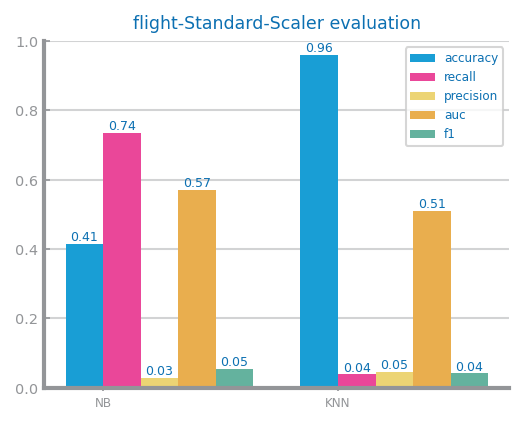

In [7]:
figure()
eval: dict[str, list] = evaluate_approach(trn_sca1, tst_sca1, target=target_name, metric="recall")
eval_metrics = {k: v for k, v in eval.items() if k != 'confusion_matrix'}
plot_multibar_chart(
    ["NB", "KNN"], eval_metrics, title=f"{file_tag}-{approach_sca1} evaluation", percentage=True
)
savefig(f"../../charts/{lab_folder_sca}/{file_tag}_{approach_sca1}_nb_vs_knn_performance.png", bbox_inches='tight')
show()

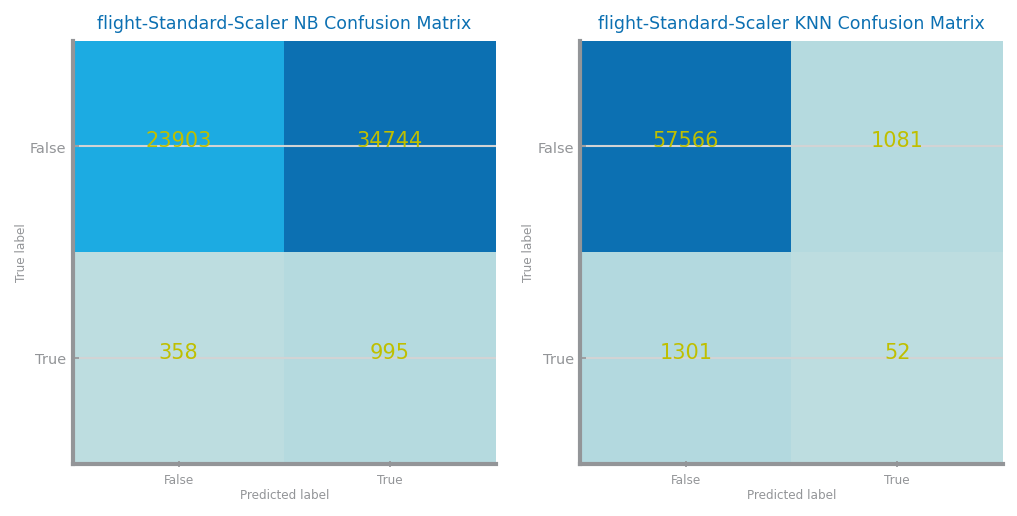

In [8]:
fig, axs = subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
labels = data_sca1[target_name].unique()
labels.sort()
plot_confusion_matrix(eval["confusion_matrix"][0], labels, ax=axs[0])
axs[0].set_title(f"{file_tag}-{approach_sca1} NB Confusion Matrix")
plot_confusion_matrix(eval["confusion_matrix"][1], labels, ax=axs[1])
axs[1].set_title(f"{file_tag}-{approach_sca1} KNN Confusion Matrix")
savefig(f"../../charts/{lab_folder_sca}/{file_tag}_{approach_sca1}_nb_vs_knn_confusion_matrix.png", bbox_inches='tight')
show()

## Approach 2: MinMaxScaler

Transform features by scaling each feature to the range [0, 1].

Formula: `x_scaled = (x - x_min) / (x_max - x_min)`

In [18]:
approach_sca2 = "MinMax-Scaler"
data_sca2 = data.copy()

# Save the original lengths to split correctly
train_len = len(train_data)

# Remove FlightDate before scaling and store it for later use
flightdate_data: Series = data_sca2.pop("FlightDate")

# Separate train and test sets without shuffling
trnX, tstX, trnY, tstY = separate_train_test_no_shuffle(data_sca2, target_name)

# Create and apply MinMaxScaler based on training data (important to avoid data leakage)
transf: MinMaxScaler = MinMaxScaler(feature_range=(0,1), copy=True).fit(trnX[numeric_vars])

trnX[numeric_vars] = DataFrame(
    transf.transform(trnX[numeric_vars]), 
    index=trnX.index, 
    columns=numeric_vars
)
tstX[numeric_vars] = DataFrame(
    transf.transform(tstX[numeric_vars]), 
    index=tstX.index, 
    columns=numeric_vars
)

# Add back the target variable as training and test sets
trn_sca2 = trnX.copy()
trn_sca2[target_name] = trnY
tst_sca2 = tstX.copy()
tst_sca2[target_name] = tstY

# Reconstruct full dataset for further analysis
data_sca2 = pd.concat([trn_sca2, tst_sca2], ignore_index=False)
data_sca2["FlightDate"] = flightdate_data

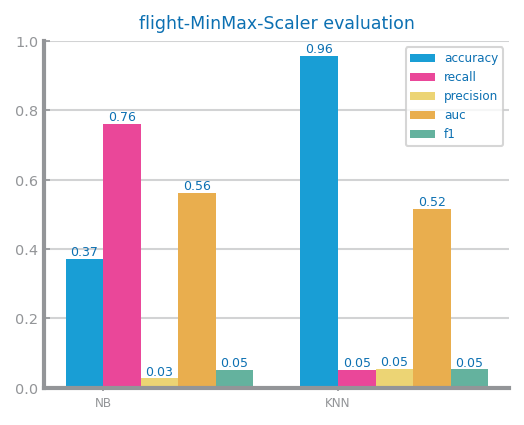

In [10]:
figure()
eval: dict[str, list] = evaluate_approach(trn_sca2, tst_sca2, target=target_name, metric="recall")
eval_metrics = {k: v for k, v in eval.items() if k != 'confusion_matrix'}
plot_multibar_chart(
    ["NB", "KNN"], eval_metrics, title=f"{file_tag}-{approach_sca2} evaluation", percentage=True
)
savefig(f"../../charts/{lab_folder_sca}/{file_tag}_{approach_sca2}_nb_vs_knn_performance.png", bbox_inches='tight')
show()

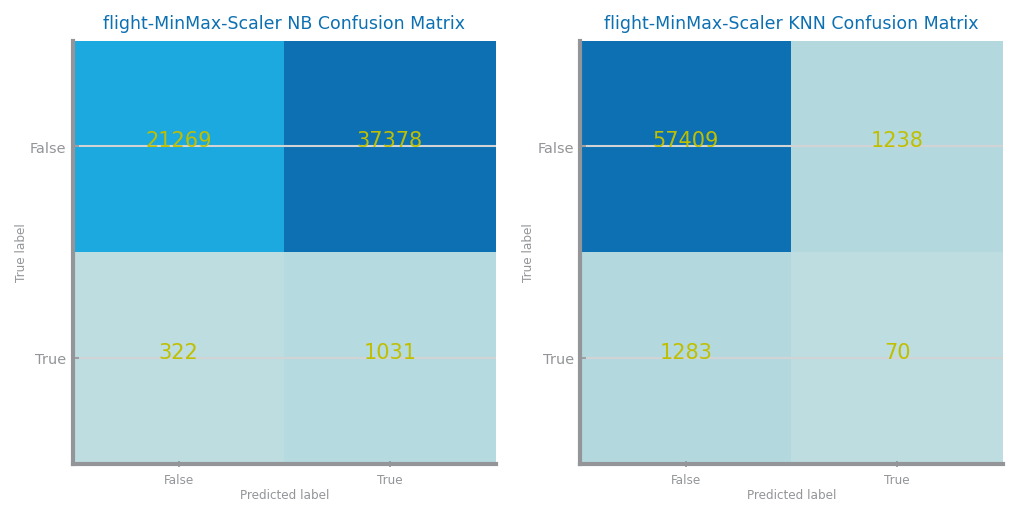

In [11]:
fig, axs = subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
labels = data_sca2[target_name].unique()
labels.sort()
plot_confusion_matrix(eval["confusion_matrix"][0], labels, ax=axs[0])
axs[0].set_title(f"{file_tag}-{approach_sca2} NB Confusion Matrix")
plot_confusion_matrix(eval["confusion_matrix"][1], labels, ax=axs[1])
axs[1].set_title(f"{file_tag}-{approach_sca2} KNN Confusion Matrix")
savefig(f"../../charts/{lab_folder_sca}/{file_tag}_{approach_sca2}_nb_vs_knn_confusion_matrix.png", bbox_inches='tight')
show()

In [19]:
# Split back to train and test using original lengths
trn_sca2_out = data_sca2.iloc[:train_len].copy()
tst_sca2_out = data_sca2.iloc[train_len:].copy()

output_train_path = "../../data/prepared/scaling/flight_train_scaling.csv"
output_test_path  = "../../data/prepared/scaling/flight_test_scaling.csv"

print("Saving scaled TRAIN to:", output_train_path)
print("Saving scaled TEST  to:", output_test_path)

trn_sca2_out.to_csv(output_train_path, index=False)
tst_sca2_out.to_csv(output_test_path,  index=False)

print("Train shape:", trn_sca2_out.shape)
print("Test  shape:", tst_sca2_out.shape)

Saving scaled TRAIN to: ../../data/prepared/scaling/flight_train_scaling.csv
Saving scaled TEST  to: ../../data/prepared/scaling/flight_test_scaling.csv
Train shape: (140000, 182)
Test  shape: (60000, 182)
